In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.get_mfccs(dataset,
                  blocksize=blocksize, 
                  overlap=overlap,
                  n_mels=128,
                  power_melgram=2.0,
                  decibel_gram=True
                 )

Epoch 1/1
2/2 [==============================] - 0s 72ms/step - loss: 1.3219


In [6]:
mfcc = pd.concat(df['mfcc'].values, keys=list(range(len(df))))
mfcc.head()

0    1    2    3    4    5    6    7    8    9    10   11   12
0 0 -860.984253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1 -860.984253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  2 -860.984253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  3 -860.984253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  4 -860.984253  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [7]:
quant = ps.quantize_mfccs(mfcc)
quant.shape

Init 1/3 with method: k-means++
Inertia for init 1/3: 367060.839385
Init 2/3 with method: k-means++
Inertia for init 2/3: 366683.679510
Init 3/3 with method: k-means++
Inertia for init 3/3: 367009.537073
Minibatch iteration 1/2800: mean batch inertia: 3.100848, ewa inertia: 3.100848 
Minibatch iteration 2/2800: mean batch inertia: 3.063231, ewa inertia: 3.098075 
Minibatch iteration 3/2800: mean batch inertia: 3.043523, ewa inertia: 3.094053 
Minibatch iteration 4/2800: mean batch inertia: 3.054557, ewa inertia: 3.091141 
Minibatch iteration 5/2800: mean batch inertia: 3.033295, ewa inertia: 3.086876 
Minibatch iteration 6/2800: mean batch inertia: 3.045605, ewa inertia: 3.083833 
Minibatch iteration 7/2800: mean batch inertia: 3.038648, ewa inertia: 3.080502 
Minibatch iteration 8/2800: mean batch inertia: 3.058549, ewa inertia: 3.078883 
Minibatch iteration 9/2800: mean batch inertia: 3.012279, ewa inertia: 3.073972 
Minibatch iteration 10/2800: mean batch inertia: 3.021142, ewa iner

Minibatch iteration 99/2800: mean batch inertia: 2.997672, ewa inertia: 2.974163 
Minibatch iteration 100/2800: mean batch inertia: 2.975562, ewa inertia: 2.974266 
Minibatch iteration 101/2800: mean batch inertia: 2.963701, ewa inertia: 2.973487 
Minibatch iteration 102/2800: mean batch inertia: 2.948542, ewa inertia: 2.971648 
Minibatch iteration 103/2800: mean batch inertia: 2.957286, ewa inertia: 2.970589 
Minibatch iteration 104/2800: mean batch inertia: 2.981890, ewa inertia: 2.971422 
Minibatch iteration 105/2800: mean batch inertia: 2.971987, ewa inertia: 2.971464 
Minibatch iteration 106/2800: mean batch inertia: 2.960520, ewa inertia: 2.970657 
Minibatch iteration 107/2800: mean batch inertia: 2.974953, ewa inertia: 2.970974 
Minibatch iteration 108/2800: mean batch inertia: 2.968944, ewa inertia: 2.970824 
Minibatch iteration 109/2800: mean batch inertia: 2.971189, ewa inertia: 2.970851 
Minibatch iteration 110/2800: mean batch inertia: 2.967475, ewa inertia: 2.970602 
Minib

(2000, 2048)

In [10]:
quant['target'] = pd.Series(dataset['target'])
quant['fold'] = dataset['fold']

In [11]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        quant[quant.fold != 1], dataset[dataset.fold != 1]['target'], test_size=0.20, random_state=42)

In [12]:
train_X = train_X.drop(['target', 'fold'], axis=1)
test_X = test_X.drop(['target', 'fold'], axis=1)

In [13]:
print(train_X.shape, train_y.shape)

(1280, 2048) (1280,)


# Training

In [25]:
from sklearn.model_selection import GridSearchCV

params = {
          'estimator__C': range(1,3),
          'estimator__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
          'estimator__gamma': ('auto', 'scale'),
          'estimator__decision_function_shape': ('ovo', 'ovr'),
          'estimator__degree': range(1,20,5)
         }

svm = OneVsRestClassifier(SVC(probability=True, max_iter=100000))

clf = GridSearchCV(svm, params, cv=5, verbose=5, n_jobs=5)

# print(help(clf))

clf.fit(train_X, train_y)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  3.1min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed: 24.2min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 68.1min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 121.5min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 193.3min
[Parallel(n_jobs=5)]: Done 640 out of 640 | elapsed: 285.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=100000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'estimator__C': range(1, 3), 'estimator__kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'estimator__decision_function_shape': ('ovo', 'ovr'), 'estimator__degree': range(1, 20, 5), 'estimator__gamma': ('auto', 'scale')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [26]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_estimator__C',
 'param_estimator__decision_function_shape',
 'param_estimator__degree',
 'param_estimator__gamma',
 'param_estimator__kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [27]:
clf.best_estimator_

OneVsRestClassifier(estimator=SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=1, gamma='scale', kernel='rbf',
  max_iter=100000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

0.3625
Confusion matrix, without normalization
[[2 0 0 ... 0 1 1]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 1 0]
 ...
 [0 0 0 ... 3 0 1]
 [0 0 1 ... 0 3 0]
 [0 0 0 ... 0 0 4]]


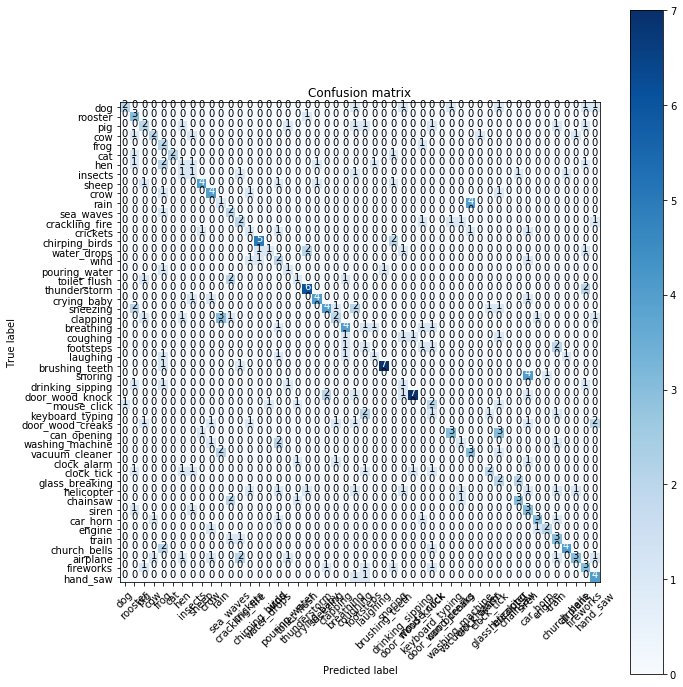

In [28]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()